In [1]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATA_DIR = Path('.', 'data', 'final', 'public')

In [3]:
train_values = pd.read_csv(DATA_DIR / 'train_values.csv', index_col='building_id')
train_labels = pd.read_csv(DATA_DIR / 'train_labels.csv', index_col='building_id')

In [4]:
train_values.dtypes

geo_level_1_id                             int64
geo_level_2_id                             int64
geo_level_3_id                             int64
count_floors_pre_eq                        int64
age                                        int64
area_percentage                            int64
height_percentage                          int64
land_surface_condition                    object
foundation_type                           object
roof_type                                 object
ground_floor_type                         object
other_floor_type                          object
position                                  object
plan_configuration                        object
has_superstructure_adobe_mud               int64
has_superstructure_mud_mortar_stone        int64
has_superstructure_stone_flag              int64
has_superstructure_cement_mortar_stone     int64
has_superstructure_mud_mortar_brick        int64
has_superstructure_cement_mortar_brick     int64
has_superstructure_t

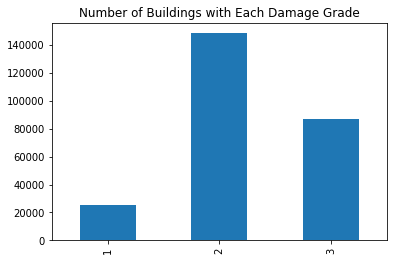

In [5]:
train_labels.damage_grade.value_counts().sort_index().plot.bar(title="Number of Buildings with Each Damage Grade")

In [6]:
selected_features = ['foundation_type', 
                     'area_percentage', 
                     'height_percentage',
                     'count_floors_pre_eq',
                     'land_surface_condition',
                     'has_superstructure_cement_mortar_stone']

train_values_subset = train_values[selected_features]

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


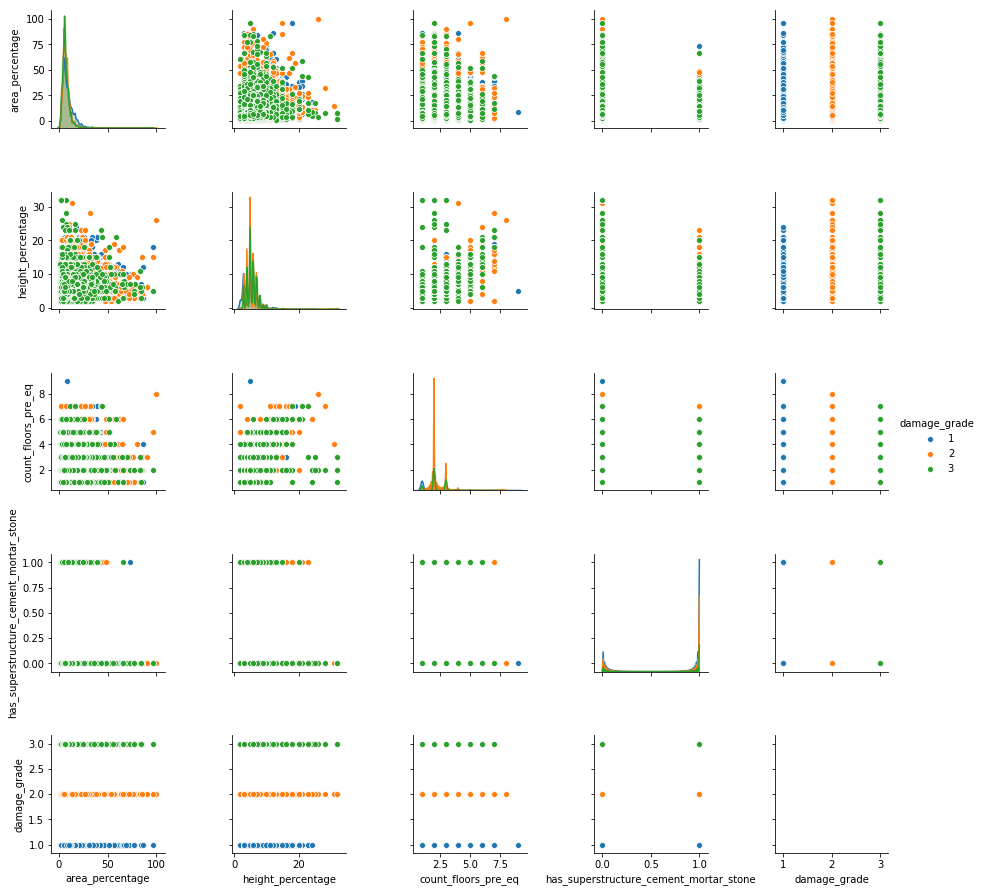

In [7]:
sns.pairplot(train_values_subset.join(train_labels), 
             hue='damage_grade')

In [8]:
train_values_subset = pd.get_dummies(train_values_subset)

In [9]:
# for preprocessing the data
from sklearn.preprocessing import StandardScaler

# the model
from sklearn.ensemble import RandomForestClassifier

# for combining the preprocess with model training
from sklearn.pipeline import make_pipeline

# for optimizing the hyperparameters of the pipeline
from sklearn.model_selection import GridSearchCV

In [10]:
pipe = make_pipeline(StandardScaler(), 
                     RandomForestClassifier(random_state=2018))
pipe

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min...obs=None,
            oob_score=False, random_state=2018, verbose=0,
            warm_start=False))])

In [11]:
param_grid = {'randomforestclassifier__n_estimators': [50, 100],
              'randomforestclassifier__min_samples_leaf': [1, 5]}
gs = GridSearchCV(pipe, param_grid, cv=5)

In [12]:
gs.fit(train_values_subset, train_labels.values.ravel())

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all conv

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min...obs=None,
            oob_score=False, random_state=2018, verbose=0,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'randomforestclassifier__n_estimators': [50, 100], 'randomforestclassifier__min_samples_leaf': [1, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [14]:
gs.best_params_

{'randomforestclassifier__min_samples_leaf': 5,
 'randomforestclassifier__n_estimators': 100}

In [15]:
from sklearn.metrics import f1_score

in_sample_preds = gs.predict(train_values_subset)
f1_score(train_labels, in_sample_preds, average='micro')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.5894183061461775

In [16]:
test_values = pd.read_csv(DATA_DIR / 'test_values.csv', index_col='building_id')

In [17]:
test_values_subset = test_values[selected_features]
test_values_subset = pd.get_dummies(test_values_subset)

In [18]:
predictions = gs.predict(test_values_subset)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [19]:
submission_format = pd.read_csv(DATA_DIR / 'submission_format.csv', index_col='building_id')

In [20]:
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [21]:
my_submission.head()

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,2
421793,2


In [22]:
my_submission.to_csv('submission.csv')

In [23]:
!type  submission.csv

submission.csv: not found
